# Multiclass clssification using sklearn
1. Classify pain, vicarious, cognitive maps based on single trials 
2. Classify pain, vicarious, cogntiive maps based on contrast maps

In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import h5py

# 1. load single trial data

check scripts/step10_nilearn/PLS/PLS.ipynb and scripts/step10_nilearn/PLS/PLS_pvc.ipynb on how the brain and behavioral data was created

In [2]:
braindf_fname = '/Volumes/seagate/cue_singletrials/singletrial_pvc.h5'
behdf_fname = '/Volumes/seagate/cue_singletrials/singletrial_pvc.csv'

with h5py.File(braindf_fname, 'r') as hdf:
    braindf = hdf['singletrial'][:]

behdf = pd.read_csv(behdf_fname)

In [3]:
braindf.shape

(38856, 98053)

In [4]:
dummy_vars = pd.get_dummies(behdf['runtype'])
merged_df = pd.concat([behdf, dummy_vars], axis=1)
# rename the dummy columns for clarity:
merged_df.rename(columns={'pain': 'dummy_pain', 'vicarious': 'dummy_vicarious', 'cognitive': 'dummy_cognitive'}, inplace=True)
# adding domain general regressor
merged_df['dummy_general'] = 1


In [5]:
merged_df.head()

,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,...,singletrial_fname,singletrial_fname_no_ext,pain_cue,vic_cue,cog_cue,gen_cue,dummy_cognitive,dummy_pain,dummy_vicarious,dummy_general
0,sub-0002_ses-03_run-01_runtype-vicarious_event...,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1,False,False,True,1
1,sub-0002_ses-03_run-01_runtype-vicarious_event...,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,False,False,True,1
2,sub-0002_ses-03_run-01_runtype-vicarious_event...,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,False,False,True,1
3,sub-0002_ses-03_run-01_runtype-vicarious_event...,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1,False,False,True,1
4,sub-0002_ses-03_run-01_runtype-vicarious_event...,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,...,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1,False,False,True,1


## plot behavioral

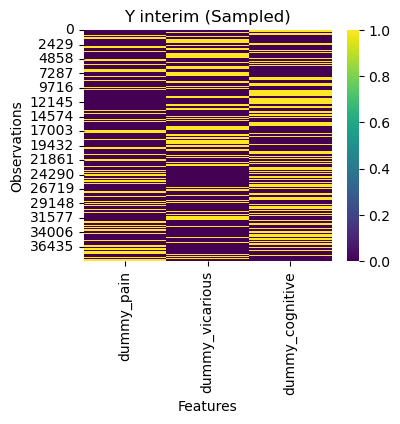

In [21]:
Ydummy = merged_df[
    ["dummy_pain", "dummy_vicarious", "dummy_cognitive"] #, "dummy_general"]
] 
Yinterim = pd.factorize(merged_df['runtype'])[0]
Xinterim = braindf  

# create groups (per subject)
codes, _ = pd.factorize(merged_df['sub'])
merged_df['groupsinterim'] = codes + 1

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(Ydummy, cmap="viridis", cbar=True)
plt.title("Y interim (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


## remove nans

In [25]:
print("7. remove nan values from X and Y")
nan_rows = Yinterim.isnull().any(axis=1)
X = Xinterim[~nan_rows]
Y = Yinterim[~nan_rows]
# merged_df[~nan_rows]
groups = merged_df['groupsinterim'][~nan_rows]
clean_indices = nan_rows[~nan_rows].index

# Assuming 'arr' is your NumPy array
# Calculate the mean of each row excluding NaN values
# arr = Y
# row_means = np.nanmean(Y, axis=1)
# inds = np.where(np.isnan(Y))  # Find the indices where NaN values are present
# for i in range(len(inds[0])):  # Replace NaNs with the mean of the corresponding row
#     Y[inds[0][i], inds[1][i]] = row_means[inds[0][i]]
print(f"after removing nan values based on the behavioral matrix, X shape is now: {X.shape}")
print(f"previously X was: {Xinterim.shape}")

7. remove nan values from X and Y


AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [24]:
Y

,dummy_pain,dummy_vicarious,dummy_cognitive
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False
...,...,...,...
38851,False,False,True
38852,False,False,True
38853,False,False,True
38854,False,False,True


In [26]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier to evaluate the model's performance on the given brain data and labels, ensuring that the cross-validation process is stratified and group-wise. The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold

import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
Y = Yinterim
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


# visualization
here I plot the 
* ROC curve and AUC
* Y vs Ypred scores and correlation
* SVM weight maps in MNI space

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and Y_pred are the true labels and predicted labels
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
## 2) y pred and y values

In [ ]:
import numpy as np

# Add jitter to Y_pred for visualization
jitter = np.random.uniform(-0.1, 0.1, size=len(Y_pred))
Y_pred_jittered = Y_pred + jitter

plt.scatter(Y, Y_pred_jittered, alpha=0.5)
plt.xlabel('True Labels (Y)')
plt.ylabel('Predicted Labels (Y_pred)')
plt.title('True vs. Predicted Labels')
plt.show()


In [ ]:
## 3) brain maps
import numpy as np

# Add jitter to Y_pred for visualization
jitter = np.random.uniform(-0.1, 0.1, size=len(Y_pred))
Y_pred_jittered = Y_pred + jitter

plt.scatter(Y, Y_pred_jittered, alpha=0.5)
plt.xlabel('True Labels (Y)')
plt.ylabel('Predicted Labels (Y_pred)')
plt.title('True vs. Predicted Labels')
plt.show()


In [ ]:
# ... (code for training and testing SVM as shown previously)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(Y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot confusion matrix
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = [f'Class {i}' for i in range(n_classes)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()

# Show the plots
plt.show()
